### Import Libraries

In [1]:
import sys
sys.path.append(r"C:\users\jaivignesh venugopal\.pyenv\pyenv-win\versions\3.6.8\lib\site-packages")

In [2]:
# Import libraries
import os 
import sys
import numpy as np
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms
import json
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Image
from tqdm import tqdm, tqdm_pandas
import random
import gc
import time
import pickle

# for vit models
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR  
import torch.nn.functional as F
import torch.optim as optim
from vit_pytorch.efficient import ViT
from linformer import Linformer

### Read in data

In [3]:
Train_pt_DIR = './train_pt'
Train_Metadata_DIR = './train_metadata.csv'
Scored_Bird_DIR ='./scored_birds.json'
Train_DIR = './train_audio/'
Audio_Rating_Dir = "./bird_audio_rating_mapping.pkl"

#ignore, to generate images
def process_get_audio_chunks_images(filename):
    chunk_duration = 5 #5sec chunk
    duration = librosa.get_duration(filename=filename)
    num_chunks = int(duration/chunk_duration)
    chunks = []
    fig, ax = plt.subplots()
    plt.figure(figsize=(14, 5))
    
    for i in range(num_chunks):
        y, sr = librosa.load(filename, offset=i*chunk_duration, duration=chunk_duration)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_DB = librosa.power_to_db(S, ref=np.max)
        
        print('S DB type is ',type(S_DB))
        print('S DB shape is ',S_DB.shape)
        
        chunks.append(S_DB)
    plt.close(fig)
    return chunks

#read in metadata as df
train_df = pd.read_csv(Train_Metadata_DIR)
train_df.head()
train_df['dir'] = Train_DIR+train_df['filename']
#print(train_df['dir'])
tqdm.pandas()
#train_df['spectogram'] = train_df.progress_apply(lambda x: process_audio_to_spectogram(x['dir']),axis=1)

In [4]:
def get_spectograms_from_file(idx):
    #get all the corresponding spectogram in np format
    bird = idx2bird[idx]
    pt_filepath = Train_pt_DIR+"/"+bird+".pt"
    x_train = torch.load(pt_filepath).view(-1,1,128,216)
    num_training_samples = x_train.shape[0]
    #y_train is one hot encoded vector per training sample
    y_train = torch.tensor(np.array([0]*len(all_birds))).view(1,-1)
    y_train[0,idx] = 1
    y_train = torch.cat([y_train]*num_training_samples)

    return x_train, y_train

In [5]:
def get_n_training_spectograms_from_file(idx, n_spectograms, TRAINING_VAL_SPLIT):
    #get n random spectogram (np format) of selected bird
    bird = idx2bird[idx]
    pt_filepath = Train_pt_DIR+"/"+bird+".pt"
    x_train = torch.load(pt_filepath).view(-1,1,128,216) # to convert to N,C, H, W format
    
    train_index = int(TRAINING_VAL_SPLIT*len(x_train)) #80:20 split for training and validation
    
    indices = torch.randint(0,train_index,(n_spectograms,)) #only sample from training pool
    selected_X_train = x_train[indices]
    
    y_train = torch.tensor(np.array([0]*len(all_birds))).view(1,-1)
    y_train[0,idx] = 1
    selected_y_train = torch.cat([y_train]*n_spectograms)
    
    return selected_X_train, selected_y_train

In [6]:
a = torch.load('./train_pt/hudgod.pt')
print(a.shape)
b = torch.load('./train_pt/redpha1.pt')
print(b.shape)

torch.Size([41, 128, 216])
torch.Size([325, 128, 216])


### EDA

In [7]:
all_birds = list(train_df.primary_label.dropna().unique())
print('Total number of birds',len(all_birds))

Total number of birds 152


In [8]:
#for mapping of bird (str) to idx (int)
bird2idx = {}
for i, bird in enumerate(all_birds):
    bird2idx[bird] = i
    
idx2bird = {}
for _, (k, v) in enumerate(bird2idx.items()): 
    idx2bird[v] = k 

In [9]:
idx2bird[151]
bird2idx['zebdov']

151

Total number of birds 152
Scored birds ['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai', 'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar', 'warwhe1', 'yefcan']
Number of scored birds training files 
 akiapo      14
aniani      12
apapan      47
barpet      15
crehon       2
elepai      14
ercfra       6
hawama      21
hawcre      20
hawgoo       9
hawhaw       3
hawpet1      3
houfin     322
iiwi        37
jabwar      78
maupar       1
omao        21
puaioh       3
skylar     500
warwhe1     71
yefcan      67
Name: primary_label, dtype: int64

Number of training files per bird


<AxesSubplot:>

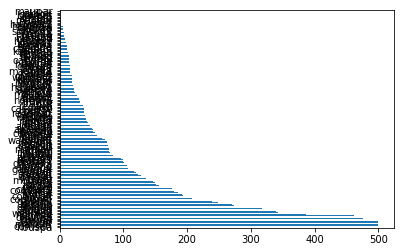

In [10]:
all_birds = list(train_df.primary_label.dropna().unique())
print('Total number of birds',len(all_birds))

#load scored birds 
with open(Scored_Bird_DIR) as sbfile:
    scored_birds = json.load(sbfile)
print('Scored birds',scored_birds)

bird_training_sample = train_df.primary_label.value_counts()

print('Number of scored birds training files \n',bird_training_sample.loc[scored_birds])
print()
print('Number of training files per bird')
bird_training_sample.plot(kind='barh')


In [11]:
#EDA, did the number of training data (5s) per bird
num_training_data = {}
for bird in tqdm(all_birds):
    _, y_train_bird = get_spectograms_from_file(bird2idx[bird])
    num_training_data[bird] = len(y_train_bird)
sorted_training_data = sorted(num_training_data.items(), key = lambda kv: kv[1])
print(sorted_training_data)

scored_bird_training = {}
for bird in tqdm(scored_birds):
    scored_bird_training[bird] = num_training_data[bird]
sorted_scored_bird_training_data = sorted(scored_bird_training.items(), key = lambda kv: kv[1])
print(sorted_scored_bird_training_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [01:09<00:00,  2.17it/s]


[('bubsan', 3), ('coopet', 4), ('shtsan', 4), ('layalb', 6), ('puaioh', 7), ('ercfra', 11), ('mauala', 15), ('akikik', 20), ('chemun', 22), ('crehon', 23), ('lessca', 28), ('hawpet1', 32), ('hawgoo', 41), ('hudgod', 41), ('brnnod', 42), ('palila', 43), ('sopsku1', 44), ('kauama', 45), ('pomjae', 47), ('hawcoo', 48), ('maupar', 49), ('chbsan', 51), ('hawhaw', 52), ('oahama', 55), ('bulpet', 63), ('wantat1', 63), ('akekee', 65), ('yebcar', 69), ('incter1', 81), ('brtcur', 82), ('aniani', 83), ('sooter1', 85), ('brnboo', 87), ('golphe', 88), ('blknod', 90), ('buffle', 92), ('afrsil1', 96), ('whttro', 97), ('cintea', 98), ('madpet', 101), ('ruff', 101), ('canvas', 107), ('masboo', 112), ('sooshe', 116), ('bkwpet', 117), ('kalphe', 119), ('whiter', 121), ('grefri', 122), ('burpar', 124), ('rinduc', 126), ('elepai', 131), ('gresca', 134), ('hawama', 140), ('akiapo', 145), ('hoomer', 162), ('gryfra', 170), ('fragul', 179), ('refboo', 185), ('lcspet', 189), ('pagplo', 191), ('whfibi', 191), ('

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 21001.52it/s]

[('puaioh', 7), ('ercfra', 11), ('crehon', 23), ('hawpet1', 32), ('hawgoo', 41), ('maupar', 49), ('hawhaw', 52), ('aniani', 83), ('elepai', 131), ('hawama', 140), ('akiapo', 145), ('barpet', 195), ('omao', 224), ('iiwi', 418), ('yefcan', 427), ('hawcre', 484), ('apapan', 493), ('warwhe1', 500), ('jabwar', 803), ('houfin', 3260), ('skylar', 5296)]


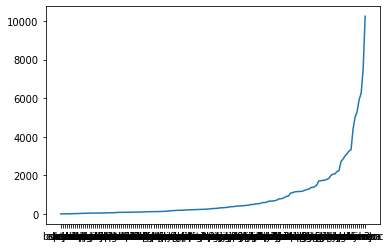

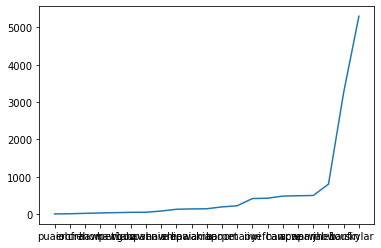

In [12]:
x, y = zip(*sorted_training_data) 
plt.plot(x, y)
plt.show()

x, y = zip(*sorted_scored_bird_training_data) 
plt.plot(x, y)
plt.show()

### Generate training data in .pt

In [13]:
'''
def get_spectograms(filename):
    chunk_duration = 5 #5sec chunk
    duration = librosa.get_duration(filename=filename)
    num_spectogram = int(duration/chunk_duration)
    spectograms = []
    for i in range(num_spectogram):
        y, sr = librosa.load(filename, offset=i*chunk_duration, duration=chunk_duration)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_DB = librosa.power_to_db(S, ref=np.max)
        spectograms.append(S_DB)
    return spectograms
'''

'\ndef get_spectograms(filename):\n    chunk_duration = 5 #5sec chunk\n    duration = librosa.get_duration(filename=filename)\n    num_spectogram = int(duration/chunk_duration)\n    spectograms = []\n    for i in range(num_spectogram):\n        y, sr = librosa.load(filename, offset=i*chunk_duration, duration=chunk_duration)\n        S = librosa.feature.melspectrogram(y=y, sr=sr)\n        S_DB = librosa.power_to_db(S, ref=np.max)\n        spectograms.append(S_DB)\n    return spectograms\n'

In [14]:
#generate pt files
'''
num_audio_files = train_df.shape[0]

spectograms_list = []
for i in tqdm(range(num_audio_files)):
    current_bird = train_df.primary_label.loc[i]
    #print('previous_bird',previous_bird)
    #print('current_bird',current_bird)
    spectograms_list += get_spectograms(train_df['dir'].iloc[i])
    if i+1 == num_audio_files:
        torch.save(torch.tensor(np.array(spectograms_list)), './train_pt/'+current_bird+'.pt')
    else:
        next_bird = train_df.primary_label.loc[i+1]
        #print('next_bird',next_bird)
        if next_bird != current_bird:
            torch.save(torch.tensor(np.array(spectograms_list)), './train_pt/'+current_bird+'.pt')
            spectograms_list = []
    previous_bird = current_bird
    #print(spectograms_list[0])
'''

"\nnum_audio_files = train_df.shape[0]\n\nspectograms_list = []\nfor i in tqdm(range(num_audio_files)):\n    current_bird = train_df.primary_label.loc[i]\n    #print('previous_bird',previous_bird)\n    #print('current_bird',current_bird)\n    spectograms_list += get_spectograms(train_df['dir'].iloc[i])\n    if i+1 == num_audio_files:\n        torch.save(torch.tensor(np.array(spectograms_list)), './train_pt/'+current_bird+'.pt')\n    else:\n        next_bird = train_df.primary_label.loc[i+1]\n        #print('next_bird',next_bird)\n        if next_bird != current_bird:\n            torch.save(torch.tensor(np.array(spectograms_list)), './train_pt/'+current_bird+'.pt')\n            spectograms_list = []\n    previous_bird = current_bird\n    #print(spectograms_list[0])\n"

In [15]:
'''
classes = train_df.primary_label.dropna().unique()
#print('classes',classes)
label_dict = { classes[i]: i  for i in range(0, len(classes) ) }    
    
batch_size = 32
num_epoch = 1

train_dataset = AudioDataset(train_df,label_dict)
dataset_len = train_dataset.__len__()
train_set_len = int(dataset_len*0.8)
val_set_len = dataset_len-train_set_len
train_set, val_set = random_split(train_dataset, [train_set_len, val_set_len])
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size, shuffle=True)
'''

"\nclasses = train_df.primary_label.dropna().unique()\n#print('classes',classes)\nlabel_dict = { classes[i]: i  for i in range(0, len(classes) ) }    \n    \nbatch_size = 32\nnum_epoch = 1\n\ntrain_dataset = AudioDataset(train_df,label_dict)\ndataset_len = train_dataset.__len__()\ntrain_set_len = int(dataset_len*0.8)\nval_set_len = dataset_len-train_set_len\ntrain_set, val_set = random_split(train_dataset, [train_set_len, val_set_len])\ntrain_dataloader = DataLoader(train_set, batch_size, shuffle=True)\nval_dataloader = DataLoader(val_set, batch_size, shuffle=True)\n"

### Get the audio rating for each of the training sample

In [16]:
'''
num_audio_files = train_df.shape[0]

def get_num_spectograms_per_audio(filename):
    chunk_duration = 5 #5sec chunk
    duration = librosa.get_duration(filename=filename)
    num_spectogram = int(duration/chunk_duration)
    
    return num_spectogram

bird_audio_rating_mapping = {}
audio_rating_list = []
for i in tqdm(range(num_audio_files)):
    current_bird = train_df.primary_label.loc[i]
    audio_rating = train_df['rating'].iloc[i]
    if audio_rating == 0:
        audio_rating = 2.5
    num_spec = get_num_spectograms_per_audio(train_df['dir'].iloc[i])
    audio_rating_list += [audio_rating]*num_spec
    if i+1 == num_audio_files:
        bird_audio_rating_mapping[current_bird] = audio_rating_list
        #torch.save(torch.tensor(np.array(spectograms_list)), './train_pt/'+current_bird+'.pt')
    else:
        next_bird = train_df.primary_label.loc[i+1]
        if next_bird != current_bird:
            bird_audio_rating_mapping[current_bird] = audio_rating_list
            #torch.save(torch.tensor(np.array(spectograms_list)), './train_pt/'+current_bird+'.pt')
            audio_rating_list = []
    previous_bird = current_bird

#save the mapping into file
rating_file = open("bird_audio_rating_mapping.pkl", "wb")
pickle.dump(bird_audio_rating_mapping, rating_file)
rating_file.close()'''

'\nnum_audio_files = train_df.shape[0]\n\ndef get_num_spectograms_per_audio(filename):\n    chunk_duration = 5 #5sec chunk\n    duration = librosa.get_duration(filename=filename)\n    num_spectogram = int(duration/chunk_duration)\n    \n    return num_spectogram\n\nbird_audio_rating_mapping = {}\naudio_rating_list = []\nfor i in tqdm(range(num_audio_files)):\n    current_bird = train_df.primary_label.loc[i]\n    audio_rating = train_df[\'rating\'].iloc[i]\n    if audio_rating == 0:\n        audio_rating = 2.5\n    num_spec = get_num_spectograms_per_audio(train_df[\'dir\'].iloc[i])\n    audio_rating_list += [audio_rating]*num_spec\n    if i+1 == num_audio_files:\n        bird_audio_rating_mapping[current_bird] = audio_rating_list\n        #torch.save(torch.tensor(np.array(spectograms_list)), \'./train_pt/\'+current_bird+\'.pt\')\n    else:\n        next_bird = train_df.primary_label.loc[i+1]\n        if next_bird != current_bird:\n            bird_audio_rating_mapping[current_bird] = au

In [17]:
rating_file = open(Audio_Rating_Dir, "rb")
bird_audio_rating_mapping = pickle.load(rating_file)
print(bird_audio_rating_mapping)
rating_file.close()

{'afrsil1': [2.5, 2.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.5, 3.5, 4.5, 4.5, 4.5, 4.5, 4.5, 2.5, 2.5, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.5, 3.5, 3.5, 3.5, 3.5], 'akekee': [4.0, 4.0, 4.0, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 4.0, 4.0, 4.0], 'akepa1': [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 4.5, 4.5, 4.5, 4.5

In [18]:
print(bird_audio_rating_mapping['blknod'])
print(len(bird_audio_rating_mapping['blknod']))
print((num_training_data['blknod']))

[4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 3.0, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
90
90


### Training

In [19]:
training_seq = [i for i in range(len(all_birds))]
random.shuffle(training_seq)
print(training_seq)
print()
training_seq_bird = [idx2bird[i] for i in training_seq]
print(training_seq_bird)

[40, 48, 129, 8, 39, 67, 15, 125, 77, 5, 29, 93, 74, 49, 36, 14, 144, 28, 7, 34, 96, 50, 140, 120, 136, 90, 83, 86, 64, 130, 11, 87, 37, 43, 58, 20, 56, 42, 128, 66, 126, 60, 30, 45, 127, 72, 100, 103, 80, 26, 23, 17, 134, 65, 79, 106, 145, 105, 150, 44, 73, 112, 81, 18, 123, 78, 141, 97, 76, 95, 115, 51, 111, 104, 122, 114, 41, 68, 12, 109, 61, 9, 35, 139, 0, 113, 6, 71, 57, 47, 89, 1, 69, 32, 53, 13, 22, 63, 3, 148, 85, 147, 16, 31, 108, 110, 88, 84, 102, 119, 10, 99, 143, 75, 25, 2, 19, 124, 121, 59, 21, 146, 33, 151, 92, 107, 70, 101, 133, 46, 24, 116, 62, 132, 27, 149, 38, 98, 55, 82, 118, 94, 91, 137, 135, 52, 138, 117, 142, 4, 54, 131]

['compea', 'eurwig', 'sheowl', 'arcter', 'commyn', 'houfin', 'blkfra', 'ruff', 'layalb', 'amewig', 'calqua', 'moudov', 'kalphe', 'fragul', 'chukar', 'bkwpet', 'wetshe', 'cacgoo1', 'apapan', 'chbsan', 'normoc', 'gadwal', 'wantat1', 'rinduc', 'sora', 'maupar', 'lobdow', 'magpet1', 'hawhaw', 'shtsan', 'belkin1', 'mallar3', 'cintea', 'coopet', 'gryfr

### Model

In [20]:
torch.cuda.empty_cache()
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(t)
print(r)
print(a)
print(f)

AssertionError: Torch not compiled with CUDA enabled

In [21]:
# For upsampling / downsampling / mixup of data
TRAINING_THRESHOLD_UPSAMPLING = 512
TRAINING_THRESHOLD_DOWNSAMPLING = 512 * 2
TRAINING_MIXUP_PERCENTAGE = 0.2 #0.2 means 20% of the training data (after up and down sampling) will be mixup 
TRAINING_SPECAUGMENT_PERCENTAGE = 0.2 #0.2 means 20% of the training data (after up and down sampling) will be spec-augment 
TRAINING_VAL_SPLIT = 0.8 #0.8 means 80% of training data will be considered for training, 20% for validation (untouched)

def get_more_samples_raw(X_train_bird,y_train_bird,additional_num_samples,rating_weights):
    #x train
    #e.g. i need 512, but i only have 500
    #total_samples = len(y_train_bird)
    indices = torch.multinomial(rating_weights,additional_num_samples,replacement=True) #generate the random index, 
    #e.g. [0,99,54,46,56,35,245,6,8,8,2]
    #indices = torch.randint(0,total_samples,(additional_num_samples,))

    additional_X_train_bird = X_train_bird[indices]
    additional_y_train_bird = y_train_bird[indices]
    
    return additional_X_train_bird, additional_y_train_bird

def get_down_samples(X_train_bird,y_train_bird,num_samples,rating_weights):
    #x train
    # i got 2000 samples, retrieve only 1024
    indices = torch.multinomial(rating_weights,num_samples)

    updated_X_train_bird = X_train_bird[indices]
    updated_y_train_bird = y_train_bird[indices]
    
    return updated_X_train_bird, updated_y_train_bird

def get_mixup_samples(X_train_bird,y_train_bird,num_mixup_sample,rating_weights,TRAINING_VAL_SPLIT):
    
    #randomly select indices from bird type 1
    source_indices = torch.randint(0,len(y_train_bird),(num_mixup_sample,))
    source_X_train = X_train_bird[source_indices]
    source_y_train = y_train_bird[source_indices]

    #--- TARGET BIRD ---
    #randomly select target bird type to mixup
    target_bird = torch.randint(0,len(all_birds),(num_mixup_sample,)) #output [10,4,7,64,32]
    bird_count = torch.bincount(target_bird) # output from bird1 - 4 times, bird 2 - 20 times 
    
    #initialise empty tensor
    target_X_train = torch.empty(0,X_train_bird.shape[1],X_train_bird.shape[2],X_train_bird.shape[3]) # N, C , H, W
    target_y_train = torch.empty(0,len(all_birds))
    for i in range(len(bird_count)):
        if bird_count[i] >0:
            add_target_X_train, add_target_y_train = get_n_training_spectograms_from_file(i, bird_count[i],TRAINING_VAL_SPLIT) #touched val_data, to be revised
            target_X_train = torch.cat((target_X_train,add_target_X_train),0)
            target_y_train = torch.cat((target_y_train,add_target_y_train),0)
    
    #Perform Mixup for source and target bird entries
    mixup_X_train = torch.zeros(num_mixup_sample,X_train_bird.shape[1],X_train_bird.shape[2],X_train_bird.shape[3])
    mixup_y_train = torch.zeros_like(target_y_train)
    for i in range(len(source_indices)):
        lambda_factor = torch.randn(1) 
        mixup_X_train[i] = source_X_train[i]*lambda_factor + target_X_train[i]*(1-lambda_factor)
        mixup_y_train[i] = source_y_train[i]*lambda_factor + target_y_train[i]*(1-lambda_factor)

    return mixup_X_train, mixup_y_train

def spec_augment(spec, num_mask=1, 
                 freq_masking_max_percentage=0.1, time_masking_max_percentage=0.1):
    
    spec = spec.detach().clone()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec

def get_specaugment_samples(X_train_bird,y_train_bird,num_specaugment_sample,rating_weights):
    source_indices = torch.randint(0,len(y_train_bird),(num_specaugment_sample,))
    specaugment_X_train = X_train_bird[source_indices]
    specaugment_y_train = y_train_bird[source_indices]
    
    for i in range(num_specaugment_sample):
        specaugment_X_train[i] = spec_augment(specaugment_X_train[i].squeeze()).view(1,X_train_bird.shape[2],X_train_bird.shape[3])

    return specaugment_X_train, specaugment_y_train

In [48]:
def train_model(model, criterion, optimizer, num_epochs, batch_size, training_seq):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in (range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        random.shuffle(training_seq)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            #print(phase)
            
            running_loss = 0.0
            running_corrects = 0
            dataset_size =0
        
            for bird_idx in tqdm(training_seq):
                X_bird, y_bird = get_spectograms_from_file(bird_idx) #get all training data for each bird
                #split to train and val set 
                
                train_index = int(TRAINING_VAL_SPLIT*len(y_bird)) #80:20 split for training and validation
                if phase == 'train':
                    #print('bird', idx2bird[bird_idx])
                    #print('shape b4',X_bird.shape)
                    X_train_bird = X_bird[0:train_index]
                    y_train_bird = y_bird[0:train_index]
                    
                    bird = idx2bird[bird_idx] #get the rating weights for sampling
                    rating_audio = bird_audio_rating_mapping[bird] #higher rating audio will have higher chance of being sampled
                    rating_audio_tensor = torch.tensor(np.array(rating_audio))
                    rating_weights = rating_audio_tensor[0:train_index]
                    #print('shape 1',X_bird.shape)
                    #upsampling and downsampling for each bird
                    if len(y_train_bird) < TRAINING_THRESHOLD_UPSAMPLING:
                        additional_num_samples = TRAINING_THRESHOLD_UPSAMPLING - len(y_train_bird) 
                        additional_X_train_bird, additional_y_train_bird = get_more_samples_raw(X_train_bird,y_train_bird,additional_num_samples,rating_weights)
                        X_train_bird = torch.cat((X_train_bird,additional_X_train_bird),0)
                        y_train_bird = torch.cat((y_train_bird,additional_y_train_bird),0)
                        #print('upsampling completed for ',idx2bird[bird_idx])
                    elif len(y_train_bird) > TRAINING_THRESHOLD_DOWNSAMPLING:
                        X_train_bird, y_train_bird = get_down_samples(X_train_bird,y_train_bird,TRAINING_THRESHOLD_DOWNSAMPLING,rating_weights)
                        #print('downsampling completed for ',idx2bird[bird_idx])
                    
                    #print('shape 2',X_bird.shape)
                    #perform mixup for each bird
                    if TRAINING_MIXUP_PERCENTAGE > 0:
                        #generate additional sample
                        num_mixup_sample = int(len(y_train_bird) * TRAINING_MIXUP_PERCENTAGE)
                        mixup_X_train_bird, mixup_y_train_bird = get_mixup_samples(X_train_bird,y_train_bird,num_mixup_sample,rating_weights,TRAINING_VAL_SPLIT)
                        #print('mixup completed for ',idx2bird[bird_idx])
                    
                    if TRAINING_SPECAUGMENT_PERCENTAGE >0:
                        num_specaugment_sample = int(len(y_train_bird) * TRAINING_SPECAUGMENT_PERCENTAGE)
                        specaugment_X_train_bird, specaugment_y_train_bird = get_specaugment_samples(X_train_bird,y_train_bird,num_specaugment_sample,rating_weights)
                        #print('specaugment_X_train_bird.shape',specaugment_X_train_bird.shape)
                        
                    if TRAINING_MIXUP_PERCENTAGE > 0:
                        #add the generated samples
                        X_train_bird = torch.cat((X_train_bird,mixup_X_train_bird),0)
                        y_train_bird = torch.cat((y_train_bird,mixup_y_train_bird),0)
                    
                    if TRAINING_SPECAUGMENT_PERCENTAGE > 0:
                        #add the generated samples
                        X_train_bird = torch.cat((X_train_bird,specaugment_X_train_bird),0)
                        y_train_bird = torch.cat((y_train_bird,specaugment_y_train_bird),0)
                        
                    #e.g.     X_train_bird.shape = (640,1,128,216)
                    dataset_size += len(y_train_bird)
                else:
                    X_train_bird = X_bird[train_index:]
                    y_train_bird = y_bird[train_index:]
                    dataset_size += (len(y_bird)-train_index-1)
                
                num_batch = -(-len(y_train_bird)//batch_size) #e.g.10
                for batch in (range(num_batch)):
                    X_train = X_train_bird[batch*batch_size : (batch+1)*batch_size]
                    y_train = y_train_bird[batch*batch_size : (batch+1)*batch_size]
                    X_train = X_train.to(device)
                    y_train = y_train.to(device)
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(X_train)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, y_train.type(torch.float))
                    
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # statistics
                    running_loss += loss.item() * X_train.size(0)
                    _,ground_truth = torch.max(y_train, 1)
                    running_corrects += torch.sum(preds == ground_truth)
                    
                    #clear memory
                    del X_train
                    del y_train
                    gc.collect()
                    torch.cuda.empty_cache()

                    
            #statistics
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            time_elapsed = time.time() - since
            print(f'Time_elapsed {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            
             # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()
        
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# MODEL = 'resnet'
MODEL = 'vit'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

if MODEL == 'resnet':
    model = models.resnet50(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, len(all_birds))
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model = model.to(device)
    
    batch_size = 64
    

if MODEL == 'vit':
    
    efficient_transformer = Linformer(
        dim=216,
        seq_len=27649, # 128 * 216 + 1 cls token
        depth=12,
        heads=8,
        k=64
        )
    
    vit_model = ViT(
        image_size=216,
        patch_size=1,
        num_classes=len(training_seq),
        dim=216,
        transformer=efficient_transformer,
        channels=1
        ).to(device)
    
    model = vit_model    
    batch_size = 192    
    
#     LR = 0.001
#     GAMMA = 0.7 #for learning rate scheduler 
#     scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)

num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=1)

model = train_model(model, criterion, optimizer, num_epochs, batch_size, training_seq)

cpu
Epoch 0/49
----------


  0%|                                                                                                                                             | 0/152 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), './model_parameters.pt')

Build A ViT Transformer